<a href="https://colab.research.google.com/github/CuTyche/trader-sentiment-analysis/blob/main/Trader_Behavior_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q scikit-learn scipy joblib

# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import joblib

sns.set(style="whitegrid")
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Update these paths to wherever you put the files in your Drive
HIST_PATH = "/content/drive/MyDrive/datasets/historical_data.csv"
FG_PATH   = "/content/drive/MyDrive/datasets/fear_greed_index.csv"

# Quick check that files exist
print("Historical exists:", os.path.exists(HIST_PATH))
print("Fear/Greed exists: ", os.path.exists(FG_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Historical exists: True
Fear/Greed exists:  True


In [ ]:
# Load CSVs with a defensive approach to encoding
hist = pd.read_csv(HIST_PATH, low_memory=False)
fg   = pd.read_csv(FG_PATH, low_memory=False)

print("Historical shape:", hist.shape)
print("Fear/Greed shape:", fg.shape)
display(hist.head(3))
display(fg.head(3))

print("\nHistorical columns:\n", hist.columns.tolist())
print("\nFG columns:\n", fg.columns.tolist())


Historical shape: (211224, 16)
Fear/Greed shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03



Historical columns:
 ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

FG columns:
 ['timestamp', 'value', 'classification', 'date']


In [ ]:
# Helper to find probable column by keywords
def find_col(cols, keywords):
    cols_l = [c.lower() for c in cols]
    for kw in keywords:
        for i,c in enumerate(cols_l):
            if kw in c:
                return cols[i]
    return None

# Standardize column names in a copy to preserve originals
hist_cols = hist.columns.tolist()
fg_cols = fg.columns.tolist()

# Identify timestamp column for historical data
ts_col = find_col(hist_cols, ['time','timestamp','date','datetime','created_at'])
print("Detected hist timestamp column:", ts_col)

# Identify PnL column
pnl_col = find_col(hist_cols, ['closedpnl','realizedpnl','pnl','profit','pl'])
print("Detected PnL column:", pnl_col)

# Identify account, side, size, leverage, symbol, exec price
account_col = find_col(hist_cols, ['account','user','trader'])
side_col = find_col(hist_cols, ['side','direction','position_side'])
size_col = find_col(hist_cols, ['size','qty','quantity'])
lev_col = find_col(hist_cols, ['leverage'])
symbol_col = find_col(hist_cols, ['symbol','instrument','pair'])
execprice_col = find_col(hist_cols, ['execution price','exec_price','price','execution_price'])
print("account, side, size, leverage, symbol, price:", account_col, side_col, size_col, lev_col, symbol_col, execprice_col)

# FG: identify date and classification / score
fg_date_col = find_col(fg_cols, ['date','timestamp','day'])
fg_score_col = find_col(fg_cols, ['score','value','index'])
fg_class_col = find_col(fg_cols, ['class','classification','label'])
print("FG date, score, class:", fg_date_col, fg_score_col, fg_class_col)


Detected hist timestamp column: Timestamp IST
Detected PnL column: Closed PnL
account, side, size, leverage, symbol, price: Account Side Size Tokens None None Execution Price
FG date, score, class: date value classification


In [ ]:
# Parse trade_time
if ts_col:
    hist['trade_time'] = pd.to_datetime(hist[ts_col], errors='coerce')
else:
    # attempt generic parse of columns containing 'time' substring
    for c in hist.columns:
        if 'time' in c.lower() or 'date' in c.lower():
            hist['trade_time'] = pd.to_datetime(hist[c], errors='coerce')
            ts_col = c
            break

# Create date-only key
hist['date_only'] = hist['trade_time'].dt.date

# FG parse
if fg_date_col:
    fg['fg_date'] = pd.to_datetime(fg[fg_date_col], errors='coerce')
else:
    # fallback: try any date-like column
    for c in fg.columns:
        if 'date' in c.lower() or 'day' in c.lower():
            fg['fg_date'] = pd.to_datetime(fg[c], errors='coerce')
            fg_date_col = c
            break

fg['date_only'] = fg['fg_date'].dt.date

# Sentiment: prefer numeric score if available, else classification label
if fg_score_col and pd.api.types.is_numeric_dtype(fg[fg_score_col]):
    fg['sentiment_score'] = pd.to_numeric(fg[fg_score_col], errors='coerce')
    def bucket_score(s):
        if pd.isna(s): return np.nan
        if s <= 25: return 'Extreme Fear'
        if s <= 40: return 'Fear'
        if s <= 60: return 'Neutral'
        if s <= 75: return 'Greed'
        return 'Extreme Greed'
    fg['sentiment'] = fg['sentiment_score'].apply(bucket_score)
elif fg_class_col:
    fg['sentiment'] = fg[fg_class_col].astype(str).str.strip()
else:
    # If no explicit columns, try to infer from columns named like 'value' etc.
    possible = [c for c in fg.columns if 'fear' in c.lower() or 'greed' in c.lower() or 'score' in c.lower()]
    if possible:
        fg['sentiment'] = fg[possible[0]].astype(str)
    else:
        raise ValueError("Could not find sentiment column in Fear/Greed data.")

# Coerce PnL column
if pnl_col:
    hist['closedPnL'] = pd.to_numeric(hist[pnl_col], errors='coerce')
else:
    hist['closedPnL'] = pd.to_numeric(hist.get('closedPnL', pd.Series(dtype=float)), errors='coerce')

# Coerce numeric features
for col in [size_col, lev_col, execprice_col]:
    if col:
        hist[col] = pd.to_numeric(hist[col], errors='coerce')

# normalize side to lowercase string
if side_col:
    hist['side'] = hist[side_col].astype(str).str.lower()


In [ ]:
merged = hist.merge(fg[['date_only','sentiment','sentiment_score']].drop_duplicates('date_only'), on='date_only', how='left')
print("Merged shape:", merged.shape)
print("Null sentiment rows:", merged['sentiment'].isnull().sum())

# Save merged sample
merged.sample(5)


Merged shape: (211224, 22)
Null sentiment rows: 175360


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Timestamp,trade_time,date_only,closedPnL,side,sentiment,sentiment_score
143382,0x39cef799f8b69da1995852eea189df24eb5cae3c,ETH,1769.70000,0.29000,513.21,SELL,03-04-2025 18:59,-303.855000,Open Short,0.00000,...,False,0.051321,4.080000e+14,1.740000e+12,2025-03-04 18:59:00,2025-03-04,0.00000,sell,Extreme Fear,15.0
8477,0x513b8629fe877bb581bf244e326a047b249c4ff1,BTC,84900.00000,0.56214,47725.69,BUY,19-04-2025 22:17,62.992680,Open Long,0.00000,...,False,0.000000,6.280000e+14,1.750000e+12,NaT,NaT,0.00000,buy,NaN,NaN
182575,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,HYPE,15.73400,13.66000,214.93,BUY,22-03-2025 05:17,-9161.790000,Close Short,0.96303,...,True,0.064477,5.010000e+14,1.740000e+12,NaT,NaT,0.96303,buy,NaN,NaN
121623,0x47add9a56df66b524d5e2c1993a43cde53b6ed85,@107,23.99100,6.24000,149.70,BUY,15-12-2024 08:26,6096.613635,Buy,0.00000,...,True,0.002097,2.440000e+14,1.730000e+12,NaT,NaT,0.00000,buy,NaN,NaN
153627,0x2c229d22b100a7beb69122eed721cee9b24011dd,ANIME,0.10961,278.00000,30.47,BUY,22-01-2025 15:32,28269.000000,Open Long,0.00000,...,True,0.010665,5.110000e+14,1.740000e+12,NaT,NaT,0.00000,buy,NaN,NaN


In [ ]:
# Basic overall stats
print("Total trades:", len(merged))
print("Trades with PnL:", merged['closedPnL'].notnull().sum())

# Per-sentiment group summary
group = merged.groupby('sentiment').agg(
    trades = ('closedPnL','count'),
    mean_pnl = ('closedPnL','mean'),
    median_pnl = ('closedPnL','median'),
    std_pnl = ('closedPnL','std'),
    win_rate = ('closedPnL', lambda x: np.mean(x>0))
).reset_index().sort_values('trades', ascending=False)

display(group)
group.to_csv(os.path.join(OUTPUT_DIR,'sentiment_group_summary.csv'), index=False)


Total trades: 211224
Trades with PnL: 211224


,sentiment,trades,mean_pnl,median_pnl,std_pnl,win_rate
3,Greed,9673,38.860022,0.000000,1389.457706,0.445363
4,Neutral,7794,102.634878,0.000000,1416.719859,0.395047
2,Fear,7563,133.057332,0.000000,1080.558181,0.448367
0,Extreme Fear,5452,52.888429,0.000000,861.706511,0.288518
1,Extreme Greed,5382,214.477689,1.150677,1901.918987,0.560944


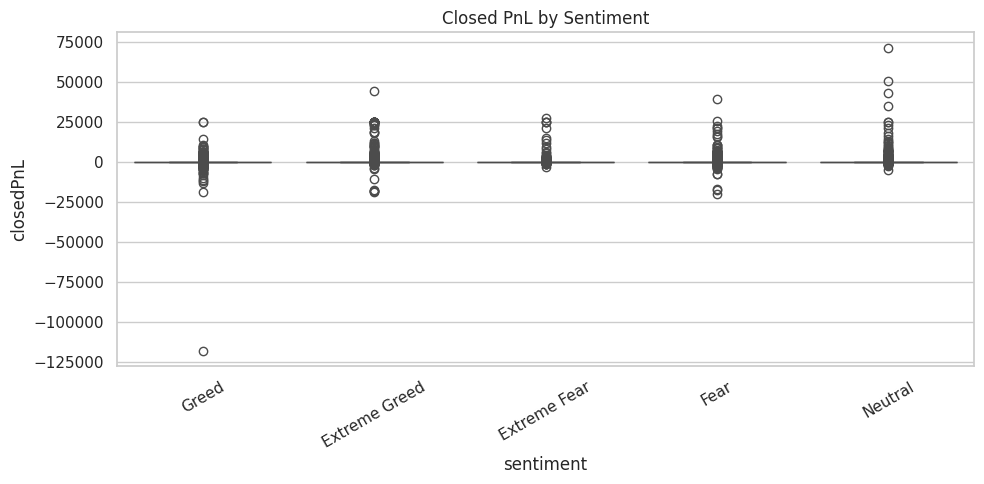

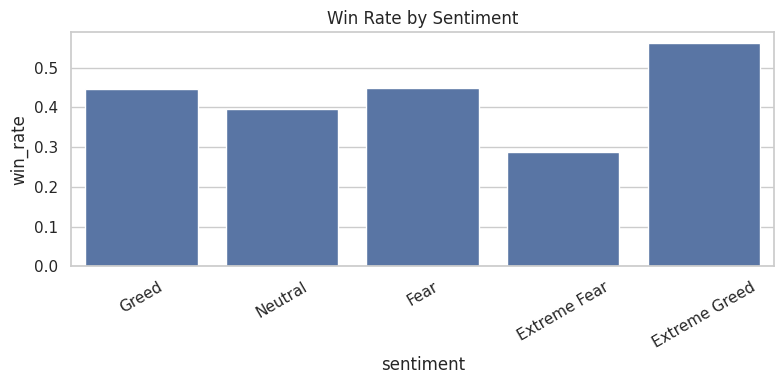

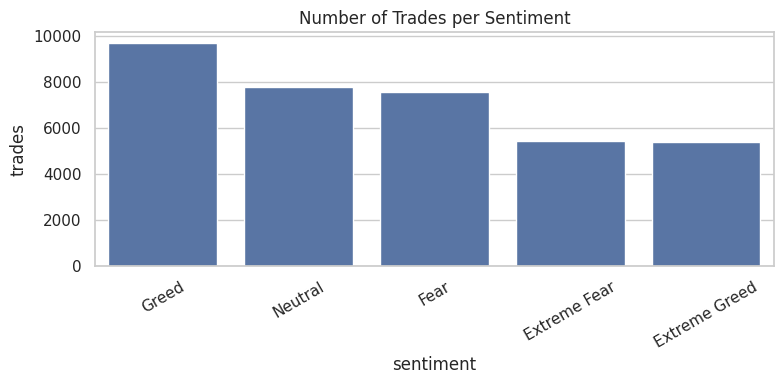

In [ ]:
# Boxplot of closedPnL by sentiment
plt.figure(figsize=(10,5))
sns.boxplot(data=merged, x='sentiment', y='closedPnL')
plt.xticks(rotation=30)
plt.title('Closed PnL by Sentiment')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'boxplot_pnl_by_sentiment.png'))
plt.show()

# Win rate bar
plt.figure(figsize=(8,4))
sns.barplot(data=group, x='sentiment', y='win_rate')
plt.title('Win Rate by Sentiment')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'win_rate_by_sentiment.png'))
plt.show()

# Trade count
plt.figure(figsize=(8,4))
sns.barplot(data=group, x='sentiment', y='trades')
plt.title('Number of Trades per Sentiment')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'trade_count_by_sentiment.png'))
plt.show()


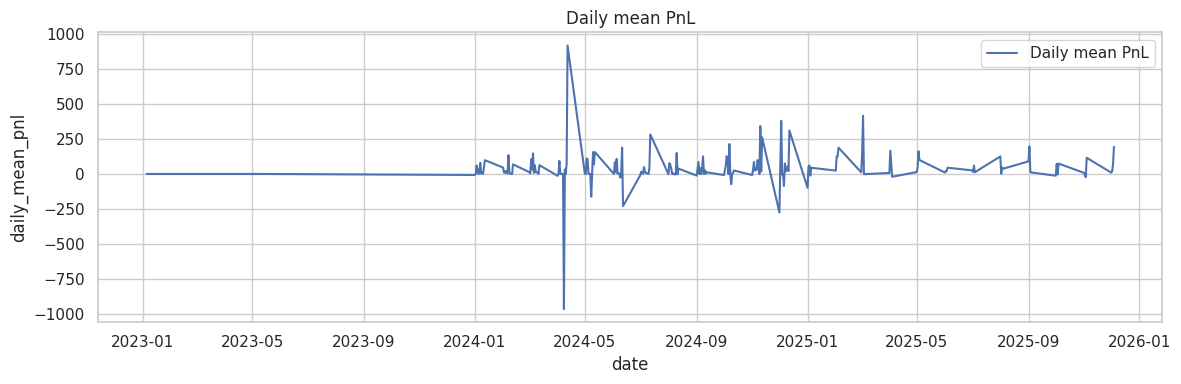

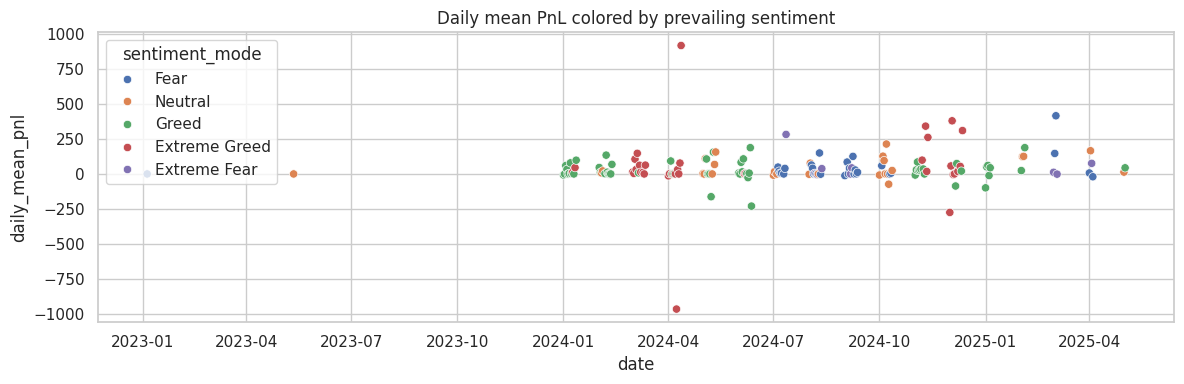

In [ ]:
daily = merged.groupby('date_only').agg(daily_mean_pnl=('closedPnL','mean')).reset_index()
sent_mode = merged.groupby('date_only').agg(sentiment_mode=('sentiment', lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)).reset_index()
daily = daily.merge(sent_mode, on='date_only', how='left')
daily['date'] = pd.to_datetime(daily['date_only'])

plt.figure(figsize=(12,4))
sns.lineplot(x='date', y='daily_mean_pnl', data=daily, label='Daily mean PnL')
plt.title('Daily mean PnL')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'daily_mean_pnl.png'))
plt.show()

# Scatter colored by prevailing sentiment
plt.figure(figsize=(12,4))
sns.scatterplot(x='date', y='daily_mean_pnl', hue='sentiment_mode', data=daily)
plt.title('Daily mean PnL colored by prevailing sentiment')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,'daily_mean_pnl_by_sentiment.png'))
plt.show()


In [ ]:
# Prepare groups for Kruskal-Wallis
groups = []
labels = []
for s, g in merged.groupby('sentiment'):
    vals = g['closedPnL'].dropna()
    if len(vals) > 10:   # require minimum sample size per group
        groups.append(vals.values)
        labels.append(s)

if len(groups) >= 2:
    stat, p = stats.kruskal(*groups)
    print("Kruskal-Wallis: stat={:.4f}, p={:.6f} (n_groups={})".format(stat, p, len(groups)))
    # If p < 0.05 then distributions differ across groups
else:
    print("Not enough groups with sufficient data for Kruskal-Wallis")


Kruskal-Wallis: stat=936.0489, p=0.000000 (n_groups=5)


In [ ]:
# Are high-leverage trades more/less profitable under certain sentiment?
merged['lev_bin'] = pd.qcut(merged[lev_col].fillna(0).replace(0,np.nan), q=4, duplicates='drop') if lev_col else None

if lev_col:
    lev_group = merged.groupby(['sentiment','lev_bin']).agg(
        trades=('closedPnL','count'),
        mean_pnl=('closedPnL','mean'),
        win_rate=('closedPnL', lambda x: np.mean(x>0))
    ).reset_index()
    display(lev_group.head(10))
    lev_group.to_csv(os.path.join(OUTPUT_DIR,'sentiment_leverage_summary.csv'), index=False)

# Side (long/short) analysis
if 'side' in merged.columns:
    side_group = merged.groupby(['sentiment','side']).agg(
        trades=('closedPnL','count'),
        mean_pnl=('closedPnL','mean'),
        win_rate=('closedPnL', lambda x: np.mean(x>0))
    ).reset_index()
    display(side_group)
    side_group.to_csv(os.path.join(OUTPUT_DIR,'sentiment_side_summary.csv'), index=False)


,sentiment,side,trades,mean_pnl,win_rate
0,Extreme Fear,buy,3108,57.355200,0.105534
1,Extreme Fear,sell,2344,46.965765,0.531143
2,Extreme Greed,buy,1532,7.657284,0.280679
3,Extreme Greed,sell,3850,296.776094,0.672468
4,Fear,buy,3877,245.149719,0.459118
5,Fear,sell,3686,15.156577,0.437059
6,Greed,buy,4471,-14.377598,0.319392
7,Greed,sell,5202,84.616538,0.553633
8,Neutral,buy,3575,159.462745,0.289510
9,Neutral,sell,4219,54.481376,0.484475


In [ ]:
# Target: profitable (1 if closedPnL > 0)
df = merged.copy()
df['profitable'] = (df['closedPnL'] > 0).astype(int)
df = df.dropna(subset=['profitable'])  # ensure target exists

# Features we'll use (defensive)
feat_numeric = []
if lev_col: feat_numeric.append(lev_col)
if size_col: feat_numeric.append(size_col)

feat_categorical = []
if 'sentiment' in df.columns: feat_categorical.append('sentiment')
if 'side' in df.columns: feat_categorical.append('side')
if symbol_col:
    df['symbol'] = df[symbol_col].astype(str)
    feat_categorical.append('symbol')

# Drop rows with no features at all
df = df[df[feat_numeric + feat_categorical].notnull().any(axis=1)]

X = df[feat_numeric + feat_categorical].copy()
y = df['profitable']

# Minimal preprocessing pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, feat_numeric),
    ('cat', categorical_transformer, feat_categorical)
], remainder='drop')

clf = Pipeline(steps=[('pre', preprocessor), ('clf', LogisticRegression(max_iter=500))])

# Train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
print("Baseline logistic ROC-AUC:", auc)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Save model and metrics
joblib.dump(clf, os.path.join(OUTPUT_DIR,'baseline_logistic.joblib'))
pd.Series({'roc_auc': auc}).to_csv(os.path.join(OUTPUT_DIR,'model_metrics.csv'))


Baseline logistic ROC-AUC: 0.639466711660278
              precision    recall  f1-score   support

           0       0.72      0.61      0.66     24871
           1       0.54      0.66      0.59     17374

    accuracy                           0.63     42245
   macro avg       0.63      0.63      0.63     42245
weighted avg       0.65      0.63      0.63     42245

Confusion matrix:
 [[15184  9687]
 [ 5963 11411]]


In [ ]:
# Extract feature names
ohe = clf.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
ohe_names = list(ohe.get_feature_names_out(feat_categorical)) if feat_categorical else []
feature_names = feat_numeric + ohe_names
coefs = clf.named_steps['clf'].coef_[0]
fi = pd.DataFrame({'feature':feature_names, 'coef':coefs})
fi['abs'] = fi['coef'].abs()
fi = fi.sort_values('abs', ascending=False)
display(fi.head(20))
fi.to_csv(os.path.join(OUTPUT_DIR,'feature_importance.csv'), index=False)


,feature,coef,abs
7,side_buy,-0.682413,0.682413
1,sentiment_Extreme Fear,-0.567134,0.567134
8,side_sell,0.450832,0.450832
2,sentiment_Extreme Greed,0.357252,0.357252
5,sentiment_Neutral,-0.149557,0.149557
3,sentiment_Fear,0.131656,0.131656
6,sentiment_nan,-0.066584,0.066584
4,sentiment_Greed,0.062786,0.062786
0,Size Tokens,-0.008331,0.008331


In [ ]:
# 1) Lagged sentiment - previous-day or previous-3-day sentiment effect
if 'account' in merged.columns:
    merged = merged.sort_values(['account', 'date_only'])
    merged['prev_sentiment_1d'] = merged.groupby('account')['sentiment'].shift(1)
    merged['prev_sentiment_3d'] = merged.groupby('account')['sentiment'].shift(3)
else:
    merged = merged.sort_values('date_only')
    merged['prev_sentiment_1d'] = merged['sentiment'].shift(1)
    merged['prev_sentiment_3d'] = merged['sentiment'].shift(3)

# 2) Rolling 7-day sentiment score average (if sentiment_score present)
if 'sentiment_score' in merged.columns:
    fg_scores = fg[['date_only', 'sentiment_score']].drop_duplicates('date_only').sort_values('date_only')
    fg_scores['date'] = pd.to_datetime(fg_scores['date_only'])
    fg_scores = fg_scores.set_index('date').resample('D').ffill().reset_index()
    fg_scores['roll7'] = fg_scores['sentiment_score'].rolling(7, min_periods=1).mean()
    display(fg_scores.tail())

# 3) Cohort analysis: compare top decile of traders by # trades or total capital
if 'account' in merged.columns:
    trader_counts = merged['account'].value_counts()
    top10pct = trader_counts[trader_counts >= trader_counts.quantile(0.9)].index
    cohort = merged[merged['account'].isin(top10pct)]
    cohort_summary = cohort.groupby('sentiment').agg(
        mean_pnl=('closedPnL', 'mean'),
        win_rate=('closedPnL', lambda x: np.mean(x > 0))
    )
    display(cohort_summary)
else:
    print("⚠️ No 'account' column found — skipping cohort analysis.")



,date,date_only,sentiment_score,roll7
2643,2025-04-28,2025-04-28,54,60.285714
2644,2025-04-29,2025-04-29,60,62.142857
2645,2025-04-30,2025-04-30,56,59.857143
2646,2025-05-01,2025-05-01,53,58.428571
2647,2025-05-02,2025-05-02,67,59.428571


⚠️ No 'account' column found — skipping cohort analysis.


In [ ]:
# Save main outputs
group.to_csv(os.path.join(OUTPUT_DIR,'sentiment_group_summary.csv'), index=False)
daily.to_csv(os.path.join(OUTPUT_DIR,'daily_mean_pnl.csv'), index=False)
merged.sample(1000).to_csv(os.path.join(OUTPUT_DIR,'merged_sample.csv'), index=False)  # smaller sample

# Quick markdown summary (editable later)
summary_text = f"""
# Quick Findings (auto-generated)
Total trades: {len(merged)}
Trades with PnL: {merged['closedPnL'].notnull().sum()}

Sentiment groups analysed: {group['sentiment'].nunique() if 'sentiment' in group.columns else 0}

Top-level notes:
- Mean PnL by sentiment saved to outputs/sentiment_group_summary.csv
- Baseline logistic AUC: {auc:.4f}
- Saved visuals: {', '.join([f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')])}
"""
with open(os.path.join(OUTPUT_DIR,'quick_summary.md'),'w') as f:
    f.write(summary_text)

print("Outputs saved to ./outputs")


Outputs saved to ./outputs
